In [61]:
import scipy.stats as stats
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score

In [52]:
df = pd.read_csv('./data/BPAT/BPAT_direct_emissions.csv')

carbon_intensity = df['carbon_intensity'].values

# Using the first 24 hours to predict the next 24 hours directly
# Extract the first 24 hours for training and the next 24 hours for testing
train_data = carbon_intensity[:24].reshape(-1, 1)  # First 24 hours
test_data = carbon_intensity[24:48].reshape(-1, 1)  # Next 24 hours

print("Train data:", train_data.flatten())
print("Test data:", test_data.flatten())

# Create the feature (X) and label (y) for training
X_train = np.arange(24).reshape(-1, 1)  # Just using the indices 0-23 as the feature
y_train = train_data  # Carbon intensity values for the first 24 hours

# Create the feature for prediction (next 24 hours)
X_test = np.arange(24, 48).reshape(-1, 1)  # Indices for the next 24 hours

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the next 24 hours
y_pred = model.predict(X_test)

# Calculate RMSE based on actual test data
rmse = np.sqrt(mean_squared_error(test_data, y_pred))

print("Predicted values:", y_pred.flatten())
print("RMSE:", rmse)

Train data: [39.34 38.05 37.65 37.36 39.36 41.36 41.91 32.65 32.8  31.12 31.47 32.74
 41.29 47.45 47.89 44.4  43.67 42.68 42.97 41.71 41.74 41.93 42.33 42.5 ]
Test data: [41.63 38.99 37.53 38.81 40.43 41.96 42.22 44.47 46.72 49.58 48.43 48.37
 48.18 47.51 44.96 41.22 40.18 39.38 40.31 41.06 42.32 43.3  45.13 45.04]
Predicted values: [43.67326087 43.97922174 44.28518261 44.59114348 44.89710435 45.20306522
 45.50902609 45.81498696 46.12094783 46.4269087  46.73286957 47.03883043
 47.3447913  47.65075217 47.95671304 48.26267391 48.56863478 48.87459565
 49.18055652 49.48651739 49.79247826 50.09843913 50.4044     50.71036087]
RMSE: 5.391772592531576


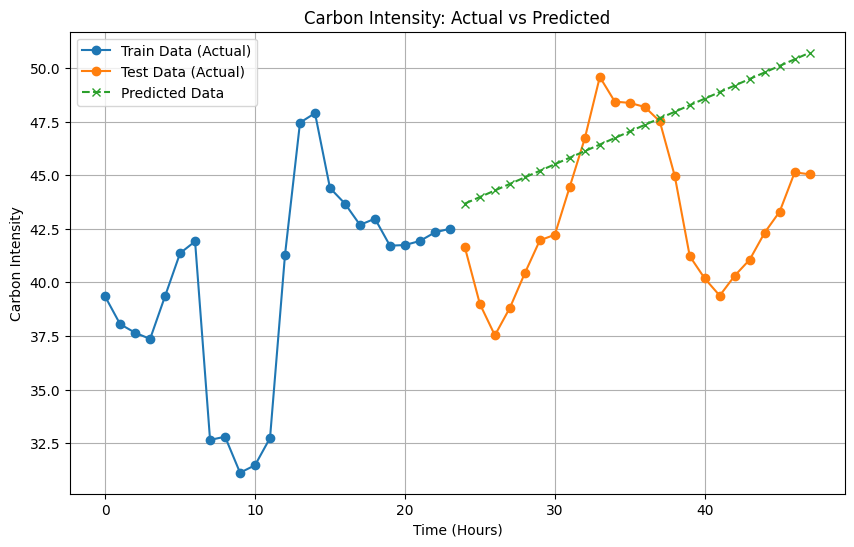

In [53]:
time_train = list(range(24))
time_test = list(range(24, 48))

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot train data
plt.plot(time_train, train_data, label="Train Data (Actual)", marker='o')

# Plot test data (actual)
plt.plot(time_test, test_data, label="Test Data (Actual)", marker='o')

# Plot predicted data
plt.plot(time_test, y_pred, label="Predicted Data", linestyle='--', marker='x')

# Add labels and title
plt.xlabel('Time (Hours)')
plt.ylabel('Carbon Intensity')
plt.title('Carbon Intensity: Actual vs Predicted')

# Show legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [54]:
# Train-Validation-Test Split: 50%-25%-25%
total_length = len(carbon_intensity)
train_size = int(0.5 * total_length)
val_size = int(0.25 * total_length)
test_size = total_length - train_size - val_size

train_data = carbon_intensity[:train_size]
val_data = carbon_intensity[train_size:train_size + val_size]
test_data = carbon_intensity[train_size + val_size:]

# Sliding window parameters
window_size = 24  # 24 hours window for input and label
step_size = 24  # Predicting 24 hours at a time

# Function to create sliding windows
def create_sliding_window(data):
    X, y = [], []
    for i in range(len(data) - 2 * window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + 2 * window_size])
    return np.array(X), np.array(y)

# Create sliding windows for training and validation
X_train, y_train = create_sliding_window(train_data)
X_val, y_val = create_sliding_window(val_data)

# Train the model using linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Validation performance
y_val_pred = model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val}")
print(f"Validation MAPE: {mape_val}")

# Testing: Forecast the next 96 hours based on the test data
def forecast_for_next_96_hours(initial_data, model, steps=4):
    predicted_values = []
    input_data = initial_data.copy()  # Start with the actual data

    for _ in range(steps):  # Each step predicts the next 24 hours
        prediction = model.predict(input_data.reshape(1, -1))
        predicted_values.extend(prediction[0])  # Add prediction to the result
        
        # Use the predicted data as input for the next 24-hour prediction
        input_data = np.concatenate([input_data[step_size:], prediction[0]])

    return predicted_values

# Start with the last 24 hours of validation data for the initial input
initial_data = val_data[-window_size:]

# Predict the next 96 hours on the test set
predicted_96_hours = forecast_for_next_96_hours(initial_data, model, steps=4)

# Calculate RMSE and MAPE for the test set
test_rmse = np.sqrt(mean_squared_error(test_data[:96], predicted_96_hours))
test_mape = mean_absolute_percentage_error(test_data[:96], predicted_96_hours)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}")

Validation RMSE: 5.257249921678747
Validation MAPE: 0.12314673071997732
Test RMSE: 11.679282201216957
Test MAPE: 0.270536372686498


In [55]:
def create_sliding_window(data):
    X, y = [], []
    for i in range(len(data) - 2 * window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + 2 * window_size])
    return np.array(X), np.array(y)

# Train-Validation-Test Split remains the same
train_data = carbon_intensity[:train_size]
val_data = carbon_intensity[train_size:train_size + val_size]
test_data = carbon_intensity[train_size + val_size:]

# Create sliding windows for training and validation
X_train, y_train = create_sliding_window(train_data)
X_val, y_val = create_sliding_window(val_data)

# Initialize the RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Validation performance
y_val_pred = model_rf.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

print(f"Validation RMSE (Random Forest): {rmse_val}")
print(f"Validation MAPE (Random Forest): {mape_val}")

# Testing: Forecast the next 96 hours based on the test data
def forecast_for_next_96_hours_rf(initial_data, model, steps=4):
    predicted_values = []
    input_data = initial_data.copy()  # Start with the actual data

    for _ in range(steps):  # Each step predicts the next 24 hours
        prediction = model.predict(input_data.reshape(1, -1))
        predicted_values.extend(prediction[0])  # Add prediction to the result
        
        # Use the predicted data as input for the next 24-hour prediction
        input_data = np.concatenate([input_data[step_size:], prediction[0]])

    return predicted_values

# Start with the last 24 hours of validation data for the initial input
initial_data = val_data[-window_size:]

# Predict the next 96 hours on the test set using the Random Forest model
predicted_96_hours_rf = forecast_for_next_96_hours_rf(initial_data, model_rf, steps=4)

# Calculate RMSE and MAPE for the test set
test_rmse_rf = np.sqrt(mean_squared_error(test_data[:96], predicted_96_hours_rf))
test_mape_rf = mean_absolute_percentage_error(test_data[:96], predicted_96_hours_rf)

print(f"Test RMSE (Random Forest): {test_rmse_rf}")
print(f"Test MAPE (Random Forest): {test_mape_rf}")

Validation RMSE (Random Forest): 5.908165403369632
Validation MAPE (Random Forest): 0.1658345691975718
Test RMSE (Random Forest): 12.288700246254345
Test MAPE (Random Forest): 0.2854940095844554


In [56]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

# Use the best estimator
best_rf = grid_search.best_estimator_

# Predict using the best model
y_val_pred = best_rf.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE (Tuned Random Forest): {rmse_val}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2

/Users/tanushsavadi/Documents/carboncast-f24/CarbonCast/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   3.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   9.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END max_depth=10, max_features=s

/Users/tanushsavadi/Documents/carboncast-f24/CarbonCast/myenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
196 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tanushsavadi/Documents/carboncast-f24/CarbonCast/myenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tanushsavadi/Documents/carboncast-f24/CarbonCast/myenv/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/tanushsavadi/Documents/carb

Best Parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Validation RMSE (Tuned Random Forest): 5.877322575084489


In [58]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("Cross-validated RMSE scores:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())

Cross-validated RMSE scores: [4.71909912 5.39495328 3.89122208 8.101773   5.70900811]
Average RMSE: 5.56321111791628


/Users/tanushsavadi/Documents/carboncast-f24/CarbonCast/myenv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tanushsavadi/Documents/carboncast-f24/CarbonCast/myenv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE (ARIMA): 5.176380523722878
Test MAPE (ARIMA): 0.11231141783635774


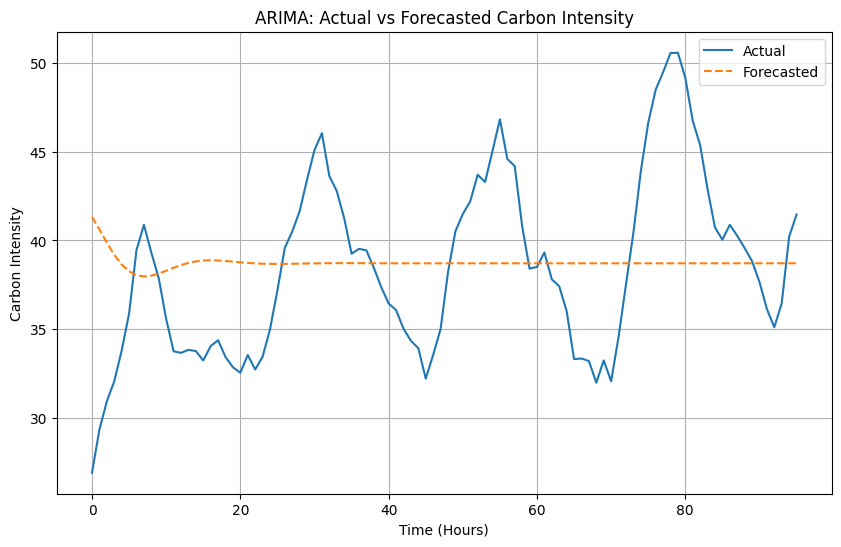

In [62]:
from statsmodels.tsa.arima.model import ARIMA
# Extract the 'carbon_intensity' column for analysis
carbon_intensity = df['carbon_intensity'].values

# Train-Validation-Test Split: 50%-25%-25%
total_length = len(carbon_intensity)
train_size = int(0.5 * total_length)
val_size = int(0.25 * total_length)
test_size = total_length - train_size - val_size

train_data = carbon_intensity[:train_size]
val_data = carbon_intensity[train_size:train_size + val_size]
test_data = carbon_intensity[train_size + val_size:]

# 1. Checking for stationarity (using simple differencing here)
# Applying ARIMA requires stationary data, so we'll check the differences.
train_diff = np.diff(train_data)

# 2. Fit the ARIMA model (using auto-regressive, differencing, and moving average)
# We choose ARIMA(p, d, q) where:
# p = number of lag observations (autoregression part)
# d = degree of differencing
# q = size of moving average window
model_arima = ARIMA(train_data, order=(5, 1, 2))  # Adjust p, d, q values based on trials
model_fit = model_arima.fit()

# 3. Predict the next 96 hours
# We use the validation data as the basis for the forecast
forecast_96_hours = model_fit.forecast(steps=96)

# 4. Evaluate the forecast on the test data (next 96 hours)
rmse = np.sqrt(mean_squared_error(test_data[:96], forecast_96_hours))
mape = mean_absolute_percentage_error(test_data[:96], forecast_96_hours)

# Print results
print(f"Test RMSE (ARIMA): {rmse}")
print(f"Test MAPE (ARIMA): {mape}")

# Optional: Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_data[:96])), test_data[:96], label="Actual")
plt.plot(range(len(forecast_96_hours)), forecast_96_hours, label="Forecasted", linestyle='--')
plt.xlabel('Time (Hours)')
plt.ylabel('Carbon Intensity')
plt.title('ARIMA: Actual vs Forecasted Carbon Intensity')
plt.legend()
plt.grid(True)
plt.show()